<a href="https://colab.research.google.com/github/CosmoStat/Tutorials/blob/power-spectrum/WL_power_spectrum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lensing $C_{\ell}$ from a map and from theory


Authors: [@b-remy](https://github.com/b-remy) (Benjamin Remy), [@dlanzieri](https://github.com/dlanzieri) (Denise Lanzieri), [@EiffL](https://github.com/EiffL) (Francois Lanusse)

## Overview

In this notebook, we will present how one can compute a power spectrum from a lensing map (in the flat sky approximation) from simulations, how to compute the corresponding theoretical spectrum and set a common units system to compare them.

### Learning goals

In this notebook, we will learn:
  - Basics of Fourier transform on images using FFT
  - How to compute a 2D power spectrum
  - How to convert a 2D power spectrum in a 1D power spectrum
  - How to convert frequencies to angular multipoles $\ell$
  - How to use a cosmology code to compute a theoreticel angular $C_\ell$

In [1]:
#@title Setup and imports
!git clone https://github.com/CosmoStat/Tutorials.git
import os
os.chdir('Tutorials')
!git checkout power-spectrum

from skimage.data import camera
from skimage.color import rgb2gray

import numpy as onp
from astropy.io import fits

!pip install --quiet jax-cosmo

import jax
import jax.numpy as np
import jax_cosmo as jc

%pylab inline

Cloning into 'Tutorials'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 1033 (delta 36), reused 56 (delta 20), pack-reused 945
Receiving objects: 100% (1033/1033), 22.62 MiB | 8.56 MiB/s, done.
Resolving deltas: 100% (451/451), done.
Branch 'power-spectrum' set up to track remote branch 'power-spectrum' from 'origin'.
Switched to a new branch 'power-spectrum'
     |████████████████████████████████| 286kB 5.6MB/s 
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['np']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Fourier transform of an image

For an image that is represented by a matrix $f[m,n]$ where $(m,n)$ are the pixel coordinates, the discrete Fourier transform (DFT) is defined as:

$$F(u,v) = \sum_m \sum_n f(m,n) e^{-i m u} e^{-i n v}$$

for $u$ and $v$ in $[0, 2\pi]$.

- Computing the one-dimensional discrete Fourier Transform can be done very efficiently with the Fast Fourrier Transform (FFT) algorithm with time complexity O(n log n).
- This algorithm can be extended to 2D signals and is present in the numpy library through `numpy.fft.fft2`.

Warning: the fft algorithm does not return the zero frequency in the center of the spectrum. We need to apply a shift to the spectrum.


In [2]:
image = camera()
data_ft = np.abs(np.fft.fft2(image))
data_ft_shifted = np.fft.fftshift(data_ft) 

Text(0.5, 1.0, 'Fourier transform shifted $|F(u,v)|$')

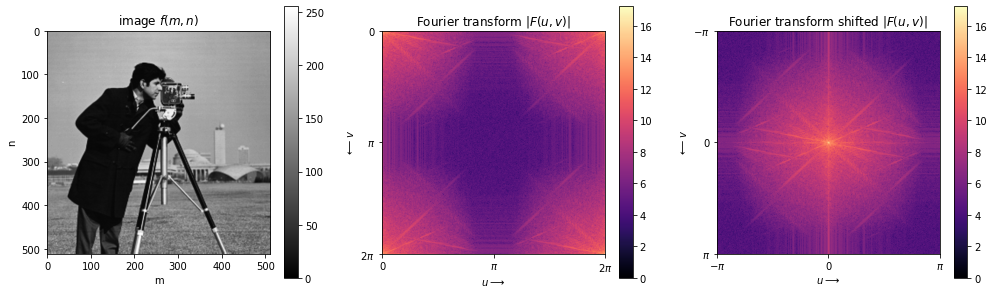

In [3]:
#@title Plot `image`, `data_ft` and `data_ft_shifted` (camera example)
fig = figure(figsize=(17,5))

axes = fig.add_subplot(131)
imshow(image, cmap='gray')
colorbar()
xlabel('m')
ylabel('n')
title(r"image $f(m,n)$")

axes = fig.add_subplot(132)
imshow(np.log(np.abs(data_ft)), cmap='magma')
colorbar()
axes.xaxis.set_ticks([0,256,512])
axes.xaxis.set_ticklabels(['0', r'$\pi$', r'$2\pi$'])
xlabel(r'$u \longrightarrow$')
axes.yaxis.set_ticks([0,256,512])
axes.yaxis.set_ticklabels(['0', r'$\pi$', r'$2\pi$'])
ylabel(r'$\longleftarrow v$')
title(r"Fourier transform $|F(u,v)|$")

axes = fig.add_subplot(133)
imshow(np.log(np.abs(data_ft_shifted)), cmap='magma')
colorbar()
axes.xaxis.set_ticks([0,256,512])
axes.xaxis.set_ticklabels([r'$-\pi$', '0', r'$\pi$'])
xlabel(r'$u \longrightarrow$')
axes.yaxis.set_ticks([0, 256, 512])
axes.yaxis.set_ticklabels([r'$-\pi$', '0', r'$\pi$'])
ylabel(r'$\longleftarrow v$')
title(r"Fourier transform shifted $|F(u,v)|$")

In [4]:
image = np.load('ktng_map.npy')
data_ft = np.abs(np.fft.fft2(image))
data_ft_shifted = np.fft.fftshift(data_ft) 

Text(0.5, 1.0, 'Fourier transform shifted $|F(u,v)|$')

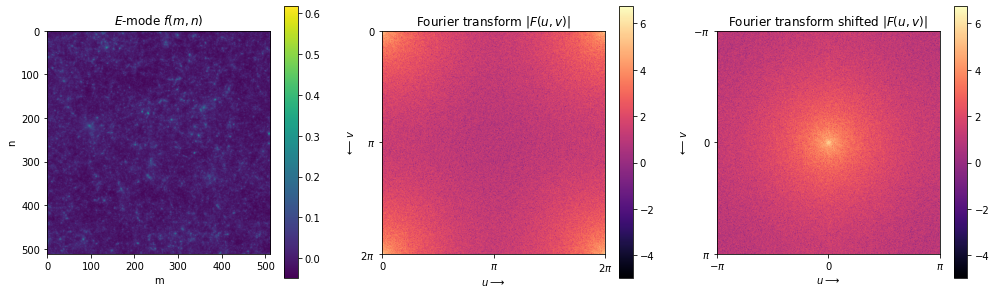

In [5]:
#@title Plot `image`, `data_ft` and `data_ft_shifted` (convergence map example)
fig = figure(figsize=(17,5))

axes = fig.add_subplot(131)
imshow(image)
colorbar()
xlabel('m')
ylabel('n')
title(r"$E$-mode $f(m,n)$")

axes = fig.add_subplot(132)
imshow(np.log(np.abs(data_ft)), cmap='magma')
colorbar()
axes.xaxis.set_ticks([0,256,512])
axes.xaxis.set_ticklabels(['0', r'$\pi$', r'$2\pi$'])
xlabel(r'$u \longrightarrow$')
axes.yaxis.set_ticks([0,256,512])
axes.yaxis.set_ticklabels(['0', r'$\pi$', r'$2\pi$'])
ylabel(r'$\longleftarrow v$')
title(r"Fourier transform $|F(u,v)|$")

axes = fig.add_subplot(133)
imshow(np.log(np.abs(data_ft_shifted)), cmap='magma')
colorbar()
axes.xaxis.set_ticks([0,256,512])
axes.xaxis.set_ticklabels([r'$-\pi$', '0', r'$\pi$'])
xlabel(r'$u \longrightarrow$')
axes.yaxis.set_ticks([0, 256, 512])
axes.yaxis.set_ticklabels([r'$-\pi$', '0', r'$\pi$'])
ylabel(r'$\longleftarrow v$')
title(r"Fourier transform shifted $|F(u,v)|$")

## Power spectrum of a map

The 2D power spectrum of the image is $|F(u,v)|^2$

In [6]:
power_spectrum_2d = np.abs(data_ft_shifted * np.conjugate(data_ft_shifted))

Text(0.5, 1.0, '2D Power spectrum $|F(u,v)|$')

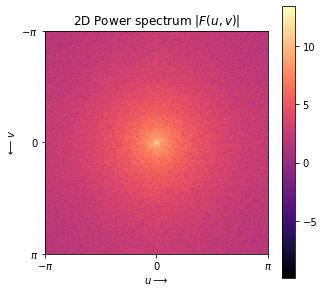

In [7]:
#@title Plot `power_spectrum_2d`
fig = figure(figsize=(5,5))
axes = fig.add_subplot(111)
imshow(np.log(power_spectrum_2d), cmap='magma')
axes.xaxis.set_ticks([0,256,512])
axes.xaxis.set_ticklabels([r'$-\pi$', '0', r'$\pi$'])
xlabel(r'$u \longrightarrow$')
axes.yaxis.set_ticks([0, 256, 512])
axes.yaxis.set_ticklabels([r'$-\pi$', '0', r'$\pi$'])
ylabel(r'$\longleftarrow v$')
colorbar()
title(r'2D Power spectrum $|F(u,v)|$')

This 2D power spectum can be summurized in a 1D plot using a **radial profile**, i.e. averaging the power at similar radius $k$.

$$k = \sqrt{u^2 + v^2}$$

In [8]:
center = data_ft.shape[0]/2
v, u = np.indices((image.shape))
k = np.sqrt((u - center)**2 + (v - center)**2)
k = k.astype('int32')

k = [[362 361 360 ... 359 360 361]
 [361 360 359 ... 359 359 360]
 [360 359 359 ... 358 359 359]
 ...
 [359 359 358 ... 357 358 359]
 [360 359 359 ... 358 359 359]
 [361 360 359 ... 359 359 360]]


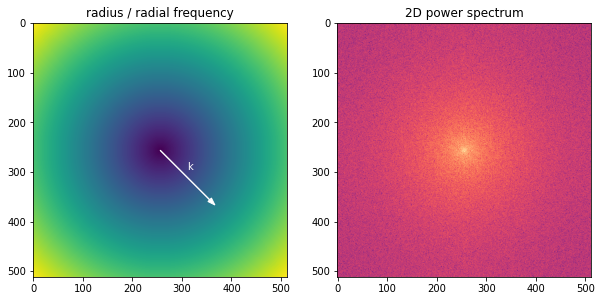

In [9]:
#@title Plot radius k

figure(figsize=(10,5))
subplot(121)
imshow(k)
arrow(x=256, y=256, dx=100, dy=100, head_width=10, fc='white', ec='white')
#circle1 = plt.Circle((256, 256), np.sqrt(2)*110, edgecolor='white', facecolor=None)
#gca().add_patch(circle1)
annotate('k', xy=(310, 295), color='white')
title('radius / radial frequency')
subplot(122)
imshow(np.log(power_spectrum_2d), cmap="magma")
title('2D power spectrum')
print('k =', k)

We then average by summing the powers with similar radius in bins and dividing by the bin size.

In [10]:
tbin = np.bincount(k.ravel(), power_spectrum_2d.ravel())
nr = np.bincount(k.ravel())
radialprofile = tbin / nr

We must be carful of the [Nyquist frequency](https://en.wikipedia.org/wiki/Nyquist_frequency), i.e. the highest frequency of a signal must be less than one-half the sampling rate (called the Nyquist frequency).

Here, the width of the spectrum being 512, we must only consider the first 256 entries of the `radialprofile`.

In [11]:
nyquist = np.int(data_ft_shifted.shape[0] / 2)
print(nyquist)

power_spectrum_1d = radialprofile[:nyquist]

256


Text(0, 0.5, '$P(k)$ [ $512^2$ pixel$^2$]')

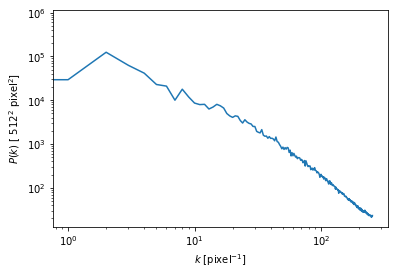

In [12]:
loglog(power_spectrum_1d)
xlabel(r'$k$ [pixel$^{-1}$]')
ylabel(r'$P(k)$ [ $512^2$ pixel$^2$]')

## Convert wavenumber $k$ to angular multipole $\ell$

In order to compare the power spectrum of a map to a theoretical one, it is necessary to convert all values to universal units, i.e. units that does not depend on map specificities (width, resolution, pixel size, etc.)

The map above is from the [kappaTNG](http://columbialensing.org/#tng) suite of simulations, thus has a resolution of 0.29 arcmin/pixels.

So we convert the Power $P(k)$ into a volume of [rad$^2$], and the $k$ to $\ell$:

In [13]:
resolution_ktng = 0.29 # pixel resolution: 0.29 arcmin/pixel
pixel_size_ktng = np.pi * resolution_ktng / 180. / 60. #rad/pixel

power_spectrum_1d *= (pixel_size_ktng)**2 / 512**2 # [rad^2]

ks = np.arange(power_spectrum_1d.shape[0])
ell = 2. * np.pi * ks / pixel_size_ktng / 360. # [rad^-1]

Text(0, 0.5, '$C_\\ell$')

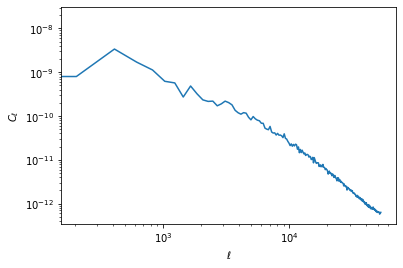

In [14]:
#@title `power_spectrum_1d` angular ell

loglog(ell, power_spectrum_1d)
xlabel(r'$\ell$')
ylabel(r'$C_\ell$')

Summary

In [15]:
def radial_profile(power_spectrum_2d):
    """
    Compute the radial profile of 2d image
    :param data: 2d image
    :return: radial profile
    """
    center = power_spectrum_2d.shape[0]/2
    v, u = np.indices((power_spectrum_2d.shape))
    k = np.sqrt((u - center)**2 + (v - center)**2)
    k = k.astype('int32')

    tbin = np.bincount(k.ravel(), power_spectrum_2d.ravel())
    nr = np.bincount(k.ravel())
    radialprofile = tbin / nr
    return radialprofile

def measure_power_spectrum(map_data, pixel_size, resolution):
    """
    measures power 2d data
    :param map_data: map (n x n)
    :param pixel_size: pixel size (rad/pixel)
    :return: ell
    :return: power spectrum
    """
    data_ft = np.abs(np.fft.fft2(map_data))
    data_ft_shifted = np.fft.fftshift(data_ft) 
    power_spectrum_2d = np.abs(data_ft_shifted * np.conjugate(data_ft_shifted))
    nyquist = np.int(data_ft_shifted.shape[0] / 2)
    radialprofile = radial_profile(power_spectrum_2d)
    power_spectrum_1d = radialprofile[:nyquist] * (pixel_size)**2 / 512**2

    # Convert frequencies to angular multipoles \ell
    k = np.arange(power_spectrum_1d.shape[0])
    #ell = k / (resolution/60)
    ell = 2. * np.pi * k / pixel_size / 360
    #ell = k * 360 / 2. / np.pi * pixel_size

    return ell, power_spectrum_1d

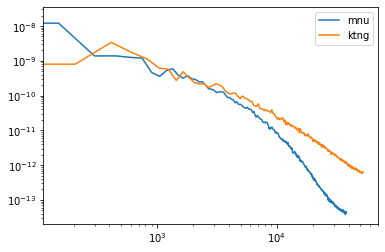

In [16]:
# MassiveNu
mnu_map = np.load('mnu_map.npy')
resolution_mnu = 0.4 # pixel resolution: 0.29 arcmin/pixel
pixel_size_mnu = np.pi * resolution_mnu / 180. / 60. #rad/pixel

ell_mnu, ps_mnu = measure_power_spectrum(mnu_map, pixel_size_mnu, resolution_mnu)

# KappaTNG
ktng_map = np.load('ktng_map.npy')
resolution_ktng = 0.29 # pixel resolution: 0.29 arcmin/pixel
pixel_size_ktng = np.pi * resolution_ktng / 180. / 60. #rad/pixel
ell_ktng, ps_ktng = measure_power_spectrum(ktng_map, pixel_size_ktng, resolution_ktng)

loglog(ell_mnu, ps_mnu, label='mnu')
loglog(ell_ktng, ps_ktng, label='ktng')
legend()

##Compute the corresponding theory spectrum
Here we show how to compute a theoretical angular Cell using the cosmology code `jax-cosmo`. \\
`jax-cosmo` is a differentiable cosmology library developed in [JAX](https://jax.readthedocs.io/en/latest/index.html), a framework for automatic differentiation.

We can define a cosmology with default parameters:

In [17]:
cosmo = jc.Planck15()

 ### Defining redshift distributions
 
 To compute the theory power spectrum, we need to be able to express the redshift distribution $n(z)$. \\
 `jax-cosmo` can implement different n(z) (the different parametrized functions can be found in the `jax_cosmo.redshift` module).  \\
 In this tutorial we compute the redshift ditribution using the kernel density estimator. \\
 KDE is defined as: 
 $$\hat{f}_h(x)=\frac{1}{n}\sum_{i=1}^n K_h(x-x_i)=\frac{1}{nh}\sum_{i=1}^n K(\frac{x-x_i}{h})$$ 
where $K$ is the kernel, a non-negative function, and $h>0$ is a smoothing parameter called the $bandwidth$. \\


 `jax-cosmo` implements a kernel-density estimate using Gaussian kernels.  
 First, we import the histograms $p(z)$ and the corresponding redshifts $z$:
 

In [18]:
z_array = np.load('z_array.npy')
pz_array=np.load('pz_array.npy')

Then, we compute the redshift distribution $n(z)$

In [19]:
nzs_s = jc.redshift.kde_nz(z_array, pz_array, bw=0.011)

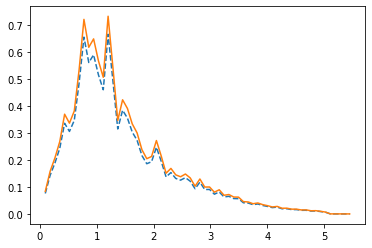

In [20]:
#let's plot the normalized Redshift distributions
c1=3.3894885098234955 # normalization factor
c2=0.08474322956787046 # normalization factor
plot(z_array, nzs_s(z_array)/c1, '--')
plot(z_array, pz_array/c2)

###Computing angular $C_\ell$
From the matter power spectrum, we can compute the theoretical expectations for the two-point correlators of pairs of quantities (fields), such as galaxy positions or galaxy shapes, and trace the matter density field in the Universe.  \\
These fields are defined by two real-valued functions of the spherical coordinates $a_1(\hat{n})$ and $a_2(\hat{n})$, from which we can define the complex field $a = a_1 + ia_2$.  \\
These fields can be decomposed into their harmonic coefficients  $_sa_{\ell m}$ through a spherical harmonic transform: \\
 $_sa_{\ell m}= \int d\hat{n}a(\hat{n})_s Y^{*}_{lm}(\hat{n}) \ \ \
  a(\hat{n})=\sum_{\ell m}$ $_{s}a_{\ell m}Y_{lm}(\hat{n})$. \\
with $ _sY_{\ell m}$ weighed spherical harmonics.

The angular power spectrum $C_\ell^{ab}$ between two fields $a$ and $b$ is defined as:
$$ \langle a_{\ell m}b_{\ell m}^{*}\rangle \equiv C^{ab} \delta_{\ell\ell'}\delta_{mm'}$$
In general, we can write the power spectrum as:
$$C_{\ell}^{ab}=4\pi \int_0^{\infty} \frac{dk}{k}
    P_{\Phi}(k) \Delta_{\ell}^a(k)\Delta_{\ell}^b(k)$$
where $P_{\Phi}(k)$ is the dimensionless power spectrum of the primordial curvature perturbations, and $\Delta^a$ and $\Delta^b$ are the transfer functions corresponding to the tracers used. 



####Definig probes
`jax_cosmo` supports two types of tracers: number counts and galaxy shape distortions. Probes are hosted in the `jax_cosmo.probes` module. A tracer of a given type contains a series of parameters, i.e. the redshift distributions and the intrinsic galaxy ellipticity in the lensing-tracer.


First, we define a list of redshift bins:

In [21]:

nzs=[nzs_s]


and one probe:

In [22]:
probes = [ jc.probes.WeakLensing(nzs, sigma_e=0.26) ]

####Limber approximation

The transfer function for the correlated galaxy shapes consists of two terms: the standard lensing $\Delta^L$ and the transfer function for intrinsic galaxy alignments $\Delta^{IA}$ . \\
 Let's consider $\Delta^L$ defined as:
$$\Delta^L_{\ell}(k)=-\frac{1}{2}\sqrt{\frac{(\ell+2)!}{(\ell-2)!}}\int \frac{dz}{H(z)}W^{L}(z)T_{\phi+\psi}(k,z)j_{\ell}(k_{\chi}(z))$$
where $W^{\ell}$ is the lensing kernel, given by 
$$W^{\ell}(z)\equiv \int_z^{\infty}dz'p_z(z')\frac{r(\chi'-\chi)}{r(\chi')r(\chi)}.$$
Computing the transfer function for a given power spectrum involves a radial projection (i.e. an integral over redshift) and thus computing full power spectra consists of a triple integral for each $\ell$. 
By using the Limber approximation: 
$$j_{\ell} (x)\simeq \sqrt{\frac{\pi}{2\ell+1}}\delta \left( \ell +\frac{1}{2}-x\right)$$
we can eliminate the integrals associated with each of the two transfer functions and make the calculation faster. \\
If we define a radial distance $\chi_{\ell} \equiv (l+1/2)/k$ for each $k$ and $\ell$ and the corresponding redshift $z_{\ell}$, substituting it in the expressions presented before, the power spectrum can be computed as a single integral: 
$$C_{\ell}^{ab}=\frac{2}{2\ell+1} \int_0^{\infty} dk
    P_{\delta}(k,z_{\ell}) \tilde \Delta_{\ell}^a(k)\tilde\Delta_{\ell}^b(k).$$
`jax_cosmo` computes the tomographic angular power spectra under the Limber approximation.

We can now compute tomographic angular power spectra for this probe using the `angular_cl` tools hosted in the `jax_cosmo.angular_cl` module. \\
First, we define  a range of $\ell$:

In [23]:
elle = np.logspace(1,5) 

And compute the data vector:

In [24]:
cls = jc.angular_cl.angular_cl(cosmo, elle, probes)

/usr/local/lib/python3.6/dist-packages/jax/_src/lax/lax.py:6341: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [25]:
cls.shape

(1, 50)

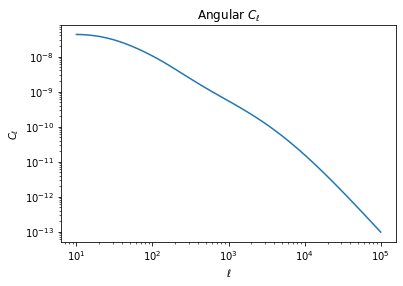

In [26]:
loglog(elle, cls[0])
ylabel(r'$C_\ell$')
xlabel(r'$\ell$');
title(r'Angular $C_\ell$');

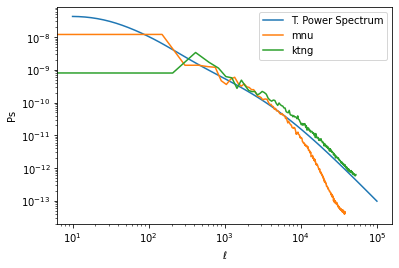

In [27]:

loglog(elle, cls[0], label='T. Power Spectrum')
loglog(ell_mnu, ps_mnu, label='mnu')
loglog(ell_ktng, ps_ktng, label='ktng')
xlabel('$\ell$')
ylabel('Ps')
legend()

Let's compare the angular $C_{\ell}$ from different redshift distributions

In [28]:
nz_source=fits.getdata('2pt_NG_mcal_1110.fits', 6)

In [29]:
nzs_dif = [jc.redshift.kde_nz(nz_source['Z_MID'].astype('float32'),
                            nz_source['BIN%d'%i].astype('float32'), 
                            bw=0.01)
           for i in range(1,5)]

(0.0, 2.0)

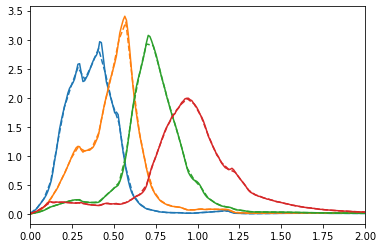

In [30]:
z = linspace(0,2)
for i in range(4):
    plot(nz_source['Z_MID'], nz_source['BIN%d'%(i+1)], color='C%d'%i)
    plot(z, nzs_dif[i](z), '--', color='C%d'%i)
xlim(0,2)

In [31]:
  probes = [ jc.probes.WeakLensing(nzs_dif, sigma_e=0.26) ]

In [32]:
elle = np.logspace(1,4) # Defines a range of \ell
cls = jc.angular_cl.angular_cl(cosmo, elle, probes)

/usr/local/lib/python3.6/dist-packages/jax/_src/lax/lax.py:6341: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


If we check the shape of these Cls

In [33]:
cls.shape

(10, 50)

 We can see we have obtained 10 spectra, each of them of size 50 (length of the $\ell$ vector). These spectra are ordered by redshift bin. So the first cls is the lensing auto-spectrum of the first bin. \\
 Note that if we used 2 probes they would be ordered first by probe, then by redshift. 

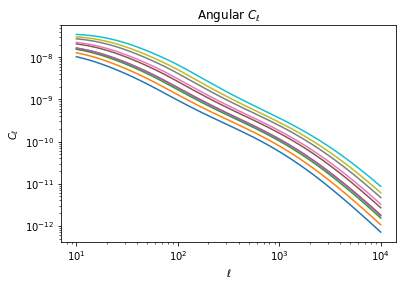

In [34]:
for i in range(10):
    loglog(elle, cls[i])
ylabel(r'$C_\ell$')
xlabel(r'$\ell$');
title(r'Angular $C_\ell$');